# Time series

**Co-author**
> - [Philip Solimine, *UBC*](https://www.psolimine.net)

**Prerequisites**

- {doc}`Python functions <../python_fundamentals/functions>`
- {doc}`GroupBy <./groupby>`

**Outcomes**

- Know how pandas handles dates
- Understand how to parse strings into `datetime` objects
- Know how to write dates as custom formatted strings
- Be able to access day, month, year, etc. for a `DateTimeIndex` and
  a column with `dtype` `datetime`
- Understand both rolling and re-sampling operations and the difference
  between the two

**Data**

- Bitcoin to USD exchange rates from March 2014 to the present


```{literalinclude} ../_static/colab_light.raw
```

In [1]:
import os
# see section on API keys at end of lecture!
import pandas as pd
import matplotlib.pyplot as plt
import nasdaqdatalink as ndl

ndl.ApiConfig.api_key = os.environ.get("NASDAQ_DATA_LINK_API_KEY", "jEKP58z7JaX6utPkkpEp")

start_date = "2014-05-01"

%matplotlib inline

## Intro

pandas has extensive support for handling dates and times.

We will loosely refer to data with date or time information as time
series data.

In this lecture, we will cover the most useful parts of pandas' time
series functionality.

Among these topics are:

- Parsing strings as dates
- Writing `datetime` objects as strings (inverse operation of previous point)
- Extracting data from a DataFrame or Series with date information in
  the index
- Shifting data through time (taking leads or lags)
- Re-sampling data to a different frequency and rolling operations

However, even more than with previous topics, we will skip a lot of the
functionality pandas offers, and we urge you to refer to the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
for more information.

## Parsing Strings as Dates

When working with time series data, we almost always receive the data
with dates encoded as strings.

Hopefully, the date strings follow a structured format or pattern.

One common pattern is `YYYY-MM-DD`: 4 numbers for the year, 2 for the
month, and 2 for the day with each section separated by a `-`.

For example, we write Christmas day 2017 in this format as

In [2]:
christmas_str = "2017-12-25"

To convert a string into a time-aware object, we use the
`pd.to_datetime` function.

In [3]:
christmas = pd.to_datetime(christmas_str)
print("The type of christmas is", type(christmas))
christmas

The type of christmas is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2017-12-25 00:00:00')

The `pd.to_datetime` function is pretty smart at guessing the format
of the date...

In [4]:
for date in ["December 25, 2017", "Dec. 25, 2017",
             "Monday, Dec. 25, 2017", "25 Dec. 2017", "25th Dec. 2017"]:
    print("pandas interprets {} as {}".format(date, pd.to_datetime(date)))

pandas interprets December 25, 2017 as 2017-12-25 00:00:00
pandas interprets Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets Monday, Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets 25 Dec. 2017 as 2017-12-25 00:00:00
pandas interprets 25th Dec. 2017 as 2017-12-25 00:00:00


However, sometimes we will need to give pandas a hint.

For example, that same time (midnight on Christmas) would be reported on
an Amazon transaction report as

In [5]:
christmas_amzn = "2017-12-25T00:00:00+ 00 :00"

If we try to pass this to `pd.to_datetime`, it will fail.

In [6]:
pd.to_datetime(christmas_amzn)

DateParseError: Unknown datetime string format, unable to parse: 2017-12-25T00:00:00+ 00 :00, at position 0

To parse a date with this format, we need to specify the `format`
argument for `pd.to_datetime`.

In [7]:
amzn_strftime = "%Y-%m-%dT%H:%M:%S+ 00 :00"
pd.to_datetime(christmas_amzn, format=amzn_strftime)

Timestamp('2017-12-25 00:00:00')

Can you guess what `amzn_strftime` represents?

Let's take a closer look at `amzn_strftime` and `christmas_amzn`.

In [8]:
print(amzn_strftime)
print(christmas_amzn)

%Y-%m-%dT%H:%M:%S+ 00 :00
2017-12-25T00:00:00+ 00 :00


Notice that both of the strings have a similar form, but that instead of actual numerical values, `amzn_strftime` has *placeholders*.

Specifically, anywhere the `%` shows up is a signal to the `pd.to_datetime`
function that it is where relevant information is stored.

For example, the `%Y` is a stand-in for a four digit year, `%m` is
for 2 a digit month, and so on...

The official [Python
documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) contains a complete list of possible `%`something patterns that are accepted
in the `format` argument.

````{admonition} Exercise
:name: pd-tim-dir1
See exercise 1 in the {ref}`exercise list <pd-tim-ex>`.
````

### Multiple Dates

If we have dates in a Series (e.g. column of DataFrame) or a list, we
can pass the entire collection to `pd.to_datetime` and get a
collection of dates back.

We'll just show an example of that here as the mechanics are the same as
a single date.

In [9]:
pd.to_datetime(["2017-12-25", "2017-12-31"])

DatetimeIndex(['2017-12-25', '2017-12-31'], dtype='datetime64[ns]', freq=None)

## Date Formatting

We can use the `%`pattern format to have pandas write `datetime`
objects as specially formatted strings using the `strftime` (string
format time) method.

For example,

In [10]:
christmas.strftime("We love %A %B %d (also written %c)")

'We love Monday December 25 (also written Mon Dec 25 00:00:00 2017)'

````{admonition} Exercise
:name: pd-tim-dir2
See exercise 2 in the {ref}`exercise list <pd-tim-ex>`.
````

## Extracting Data

When the index of a DataFrame has date information and pandas
recognizes the values as `datetime` values, we can leverage some
convenient indexing features for extracting data.

The flexibility of these features is best understood through example,
so let's load up some data and take a look.

In [11]:
btc_usd_long = ndl.get_table("QDL/BCHAIN", date = { 'gte': '2009-12-25', 'lte': '2019-01-01' }, code = ["MKPRU", "MKTCP", "ETRVU"])
btc_usd_long.info()
btc_usd_long.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9885 entries, 0 to 9884
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   code    9885 non-null   object        
 1   date    9885 non-null   datetime64[ns]
 2   value   9885 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 231.8+ KB


,code,date,value
None,,,
0,MKTCP,2019-01-01,6.550566e+10
1,MKTCP,2018-12-31,6.638886e+10
2,MKTCP,2018-12-30,6.689905e+10
3,MKTCP,2018-12-29,6.827565e+10
4,MKTCP,2018-12-28,6.709189e+10


Here, we have the Bitcoin (BTC) to US dollar (USD) exchange rate from
2009 until today, as well as other variables relevant to the Bitcoin ecosystem, in long ("melted") form.

In [12]:
print(btc_usd_long.code.unique())
btc_usd_long.dtypes

['MKTCP' 'MKPRU' 'ETRVU']


code             object
date     datetime64[ns]
value           float64
dtype: object

Notice that the type of `date` is `datetime`. We would like this to be the index, and we want to drop the long form. We also selected only a couple of columns of interest, but the dataset has a lot more options. (The column descriptions can be found [here](https://data.nasdaq.com/databases/BCHAIN)). We chose Market Price (in USD) (`MKPRU`), Total Market Cap (`MKTCP`), and Estimated Transaction Volume in USD (`ETRVU`).

In [13]:
btc_usd = btc_usd_long.pivot_table(index='date', columns='code', values='value')
btc_usd.head()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,0.0,0.0,0.0
2009-12-26,0.0,0.0,0.0
2009-12-27,0.0,0.0,0.0
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0


Now that we have a datetime index, it enables things like...

Extracting all data for the year 2015 by passing `"2015"` to `.loc`.

In [14]:
btc_usd.loc["2015"]

code,ETRVU,MKPRU,MKTCP
date,,,
2015-01-01,2.831524e+07,316.15,4.388454e+09
2015-01-02,5.458287e+07,314.81,4.136728e+09
2015-01-03,9.035606e+07,270.93,3.708212e+09
2015-01-04,6.263383e+07,276.80,3.901250e+09
2015-01-05,5.647246e+07,263.17,3.790804e+09
...,...,...,...
2015-12-27,7.700877e+07,418.46,6.420190e+09
2015-12-28,1.057652e+08,422.42,6.366855e+09
2015-12-29,1.158679e+08,431.13,6.475864e+09


We can also narrow down to specific months.

In [15]:
# By month's name
btc_usd.loc["August 2017"]

code,ETRVU,MKPRU,MKTCP
date,,,
2017-08-01,1.369196e+09,2862.9000,4.550093e+10
2017-08-02,1.424506e+09,2693.6340,4.440385e+10
2017-08-03,9.709563e+08,2794.1177,4.606512e+10
2017-08-04,1.196485e+09,2790.0000,4.631086e+10
2017-08-05,9.791541e+08,3218.1150,5.306965e+10
2017-08-06,1.044204e+09,3252.5625,5.364342e+10
2017-08-07,1.385571e+09,3210.2000,5.319216e+10
2017-08-08,1.230026e+09,3457.3743,5.703501e+10
2017-08-09,8.071196e+08,3357.3263,5.526816e+10


In [16]:
# By month's number
btc_usd.loc["08/2017"]

code,ETRVU,MKPRU,MKTCP
date,,,
2017-08-01,1.369196e+09,2862.9000,4.550093e+10
2017-08-02,1.424506e+09,2693.6340,4.440385e+10
2017-08-03,9.709563e+08,2794.1177,4.606512e+10
2017-08-04,1.196485e+09,2790.0000,4.631086e+10
2017-08-05,9.791541e+08,3218.1150,5.306965e+10
2017-08-06,1.044204e+09,3252.5625,5.364342e+10
2017-08-07,1.385571e+09,3210.2000,5.319216e+10
2017-08-08,1.230026e+09,3457.3743,5.703501e+10
2017-08-09,8.071196e+08,3357.3263,5.526816e+10


Or even a day...

In [17]:
# By date name
btc_usd.loc["August 1, 2017"]

code
ETRVU    1.369196e+09
MKPRU    2.862900e+03
MKTCP    4.550093e+10
Name: 2017-08-01 00:00:00, dtype: float64

In [18]:
# By date number
btc_usd.loc["08-01-2017"]

code
ETRVU    1.369196e+09
MKPRU    2.862900e+03
MKTCP    4.550093e+10
Name: 2017-08-01 00:00:00, dtype: float64

What can we pass as the `.loc` argument when we have a
`DateTimeIndex`?

Anything that can be converted to a `datetime` using
`pd.to_datetime`, *without* having to specify the format argument.

When that condition holds, pandas will return *all* rows whose date in
the index "belong" to that date or period.

We can also use the range shorthand notation to give a start and end
date for selection.

In [19]:
btc_usd.loc["April 1, 2015":"April 10, 2015"]

code,ETRVU,MKPRU,MKTCP
date,,,
2015-04-01,5.354486e+07,252.44,3.536773e+09
2015-04-02,4.016409e+07,246.49,3.565053e+09
2015-04-03,4.331351e+07,253.77,3.549561e+09
2015-04-04,2.205524e+07,257.03,3.604010e+09
2015-04-05,2.832354e+07,253.67,3.572161e+09
2015-04-06,3.991755e+07,255.48,3.584116e+09
2015-04-07,5.134161e+07,245.89,3.579212e+09
2015-04-08,5.092222e+07,253.90,3.438417e+09
2015-04-09,5.215728e+07,235.71,3.309144e+09


````{admonition} Exercise
:name: pd-tim-dir3
See exercise 3 in the {ref}`exercise list <pd-tim-ex>`.
````

## Accessing Date Properties

Sometimes, we would like to directly access a part of the date/time.

If our date/time information is in the index, we can to `df.index.XX`
where `XX` is replaced by `year`, `month`, or whatever we would
like to access.

In [20]:
btc_usd.index.year

Index([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010,
       ...
       2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2019],
      dtype='int32', name='date', length=3295)

In [21]:
btc_usd.index.day

Index([25, 26, 27, 28, 29, 30, 31,  1,  2,  3,
       ...
       23, 24, 25, 26, 27, 28, 29, 30, 31,  1],
      dtype='int32', name='date', length=3295)

We can also do the same if the date/time information is stored in a
column, but we have to use a slightly different syntax.

```{code-block} python
df["column_name"].dt.XX
```

In [22]:
btc_date_column = btc_usd.reset_index()
btc_date_column.head()

code,date,ETRVU,MKPRU,MKTCP
0,2009-12-25,0.0,0.0,0.0
1,2009-12-26,0.0,0.0,0.0
2,2009-12-27,0.0,0.0,0.0
3,2009-12-28,0.0,0.0,0.0
4,2009-12-29,0.0,0.0,0.0


In [23]:
btc_date_column["date"].dt.year.head()

0    2009
1    2009
2    2009
3    2009
4    2009
Name: date, dtype: int32

In [24]:
btc_date_column["date"].dt.month.head()

0    12
1    12
2    12
3    12
4    12
Name: date, dtype: int32

## Leads and Lags: `df.shift`

When doing time series analysis, we often want to compare data at one
date against data at another date.

pandas can help us with this if we leverage the `shift` method.

Without any additional arguments, `shift()` will move all data
*forward* one period, filling the first row with missing data.

In [25]:
# so we can see the result of shift clearly
btc_usd.head()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,0.0,0.0,0.0
2009-12-26,0.0,0.0,0.0
2009-12-27,0.0,0.0,0.0
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0


In [26]:
btc_usd.shift().head()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,NaN,NaN,NaN
2009-12-26,0.0,0.0,0.0
2009-12-27,0.0,0.0,0.0
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0


We can use this to compute the percent change from one day to the next.
(Quiz: Why does that work? Remember how pandas uses the index to *align*
data.)

In [27]:
((btc_usd - btc_usd.shift()) / btc_usd.shift()).head()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,NaN,NaN,NaN
2009-12-26,NaN,NaN,NaN
2009-12-27,NaN,NaN,NaN
2009-12-28,NaN,NaN,NaN
2009-12-29,NaN,NaN,NaN


Setting the first argument to `n` tells pandas to shift the data down
`n` rows (apply an `n` period lag).

In [28]:
btc_usd.shift(3).head()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,NaN,NaN,NaN
2009-12-26,NaN,NaN,NaN
2009-12-27,NaN,NaN,NaN
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0


A negative value will shift the data *up* or apply a lead.

In [29]:
btc_usd.shift(-2).head()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,0.0,0.0,0.0
2009-12-26,0.0,0.0,0.0
2009-12-27,0.0,0.0,0.0
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0


In [30]:
btc_usd.shift(-2).tail()

code,ETRVU,MKPRU,MKTCP
date,,,
2018-12-28,2.700024e+08,3770.3600,6.689905e+10
2018-12-29,4.760031e+08,3791.5458,6.638886e+10
2018-12-30,2.236265e+08,3752.2717,6.550566e+10
2018-12-31,NaN,NaN,NaN
2019-01-01,NaN,NaN,NaN


````{admonition} Exercise
:name: pd-tim-dir4
See exercise 4 in the {ref}`exercise list <pd-tim-ex>`.
````

## Rolling Computations: `.rolling`

pandas has facilities that enable easy computation of *rolling
statistics*.

These are best understood by example, so we will dive right in.

In [31]:
# first take only the first 6 rows so we can easily see what is going on
btc_small = btc_usd.head(6)
btc_small

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,0.0,0.0,0.0
2009-12-26,0.0,0.0,0.0
2009-12-27,0.0,0.0,0.0
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0
2009-12-30,0.0,0.0,0.0


Below, we compute the 2 day moving average (for all columns).

In [32]:
btc_small.rolling("2d").mean()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,0.0,0.0,0.0
2009-12-26,0.0,0.0,0.0
2009-12-27,0.0,0.0,0.0
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0
2009-12-30,0.0,0.0,0.0


To do this operation, pandas starts at each row (date) then looks
*backwards* the specified number of periods (here 2 days) and then
applies some aggregation function (`mean`) on all the data in that
window.

If pandas cannot look back the full length of the window (e.g. when
working on the first row), it fills as much of the window as possible
and then does the operation. Notice that the value at 2014-05-01 is
the same in both DataFrames.

Below, we see a visual depiction of the rolling maximum on a 21 day
window for the whole dataset.

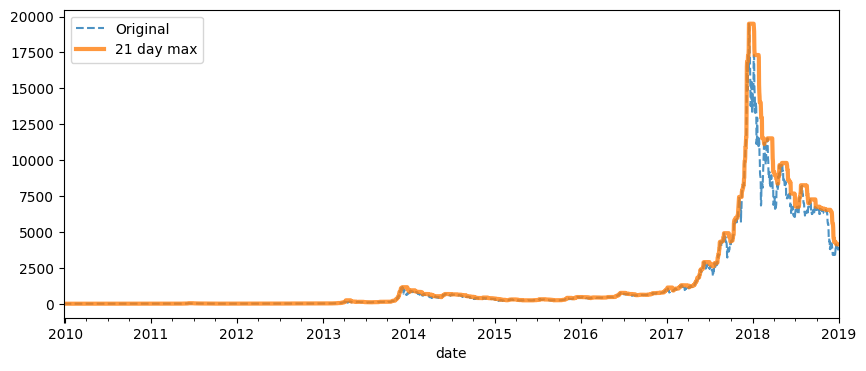

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))
btc_usd["MKPRU"].plot(ax=ax, linestyle="--", alpha=0.8)
btc_usd.rolling("21d").max()["MKPRU"].plot(ax=ax, alpha=0.8, linewidth=3)
ax.legend(["Original", "21 day max"])

We can also ask pandas to `apply` custom functions, similar to what we
saw when studying GroupBy.

In [34]:
def is_volatile(x):
    "Returns a 1 if the variance is greater than 1, otherwise returns 0"
    if x.var() > 1.0:
        return 1.0
    else:
        return 0.0

In [35]:
btc_small.rolling("2d").apply(is_volatile)

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-25,0.0,0.0,0.0
2009-12-26,0.0,0.0,0.0
2009-12-27,0.0,0.0,0.0
2009-12-28,0.0,0.0,0.0
2009-12-29,0.0,0.0,0.0
2009-12-30,0.0,0.0,0.0


````{admonition} Exercise
:name: pd-tim-dir5
See exercise 5 in the {ref}`exercise list <pd-tim-ex>`.
````

To make the optimal decision, we need to know the maximum
difference between the close price at the end of the window and the open
price at the start of the window.

````{admonition} Exercise
:name: pd-tim-dir6
See exercise 6 in the {ref}`exercise list <pd-tim-ex>`.
````

## Changing Frequencies: `.resample`

In addition to computing rolling statistics, we can also change the
frequency of the data.

For example, instead of a monthly moving average, suppose that we wanted
to compute the average *within* each calendar month.

We will use the `resample` method to do this.

Below are some examples.

In [36]:
# business quarter
btc_usd.resample("BQE").mean()

code,ETRVU,MKPRU,MKTCP
date,,,
2009-12-31,0.000000e+00,0.000000,0.000000e+00
2010-03-31,0.000000e+00,0.000000,0.000000e+00
2010-06-30,0.000000e+00,0.000000,0.000000e+00
2010-09-30,8.522276e+02,0.033260,1.317223e+05
2010-12-31,1.179063e+04,0.217938,1.015812e+06
2011-03-31,4.516475e+04,0.737402,4.043357e+06
2011-06-30,1.729951e+06,9.176310,5.956523e+07
2011-09-30,9.176091e+05,10.742849,7.522893e+07
2011-12-30,1.991838e+06,3.419525,2.639635e+07


Note that unlike with `rolling`, a single number is returned for
each column for each quarter.

The `resample` method will alter the frequency of the data and the
number of rows in the result will be different from the number of rows
in the input.

On the other hand, with `rolling`, the size and frequency of the result
are the same as the input.

We can sample at other frequencies and aggregate with multiple aggregations
function at once.

In [37]:
# multiple functions at 2 start-of-quarter frequency
btc_usd.resample("2BQS").agg(["min", "max"])

code               ETRVU                    MKPRU                     MKTCP  \
                     min           max        min         max           min   
date                                                                          
2009-10-01  0.000000e+00  0.000000e+00     0.0000      0.0000  0.000000e+00   
2010-04-01  0.000000e+00  4.780000e+03     0.0000      0.1750  0.000000e+00   
2010-10-01  1.649000e+03  2.441970e+05     0.0600      1.1000  2.493210e+05   
2011-04-01  2.740300e+04  1.815384e+07     0.7100     35.0000  4.150234e+06   
2011-10-03  1.975250e+05  1.637516e+07     2.2900      7.2200  1.766128e+07   
2012-04-02  4.122260e+05  1.322970e+07     4.8000     15.4000  4.195824e+07   
2012-10-01  7.742860e+05  2.769433e+07    10.6010     93.5670  1.093527e+08   
2013-04-01  9.821585e+06  1.385370e+08    67.8584    237.9900  7.519925e+08   
2013-10-01  1.150644e+07  3.843574e+08   103.8500   1151.0000  1.230957e+09   
2014-04-01  1.976148e+07  1.765106e+08   380.0000    673.9000  4.661392e+09   
2014-10-01  2.502690e+07  1.781682e+08   176.5000    430.0700  2.707305e+09   
2015-04-01  2.205524e+07  1.056422e+08   216.0000    310.5500  3.077795e+09   
2015-10-01  4.002130e+07  3.353970e+08   237.7800    463.9800  3.486830e+09   
2016-04-01  7.246670e+07  4.338279e+08   416.2500    754.3600  6.402758e+09   
2016-10-03  1.006182e+08  5.526767e+08   607.1800   1287.0000  9.676305e+09   
2017-04-03  1.955462e+08  1.772644e+09  1079.9900   4911.7400  1.846992e+10   
2017-10-02  5.506455e+08  5.729890e+09  4225.1750  19498.6833  7.021588e+10   
2018-04-02  2.724822e+08  1.986371e+09  5908.7025   9803.3067  1.005508e+11   
2018-10-01  2.236265e+08  2.721201e+09  3242.4200   6626.8500  5.620096e+10   

code                      
                     max  
date                      
2009-10-01  0.000000e+00  
2010-04-01  6.992825e+05  
2010-10-01  5.901940e+06  
2011-04-01  2.272585e+08  
2011-10-03  5.811768e+07  
2012-04-02  1.496572e+08  
2012-10-01  1.125488e+09  
2013-04-01  2.620841e+09  
2013-10-01  1.350490e+10  
2014-04-01  8.668279e+09  
2014-10-01  5.802913e+09  
2015-04-01  4.464575e+09  
2015-10-01  6.952138e+09  
2016-04-01  1.212991e+10  
2016-10-03  2.089075e+10  
2017-04-03  7.969529e+10  
2017-10-02  3.346692e+11  
2018-04-02  1.668274e+11  
2018-10-01  1.146456e+11

As with `groupby` and `rolling`, you can also provide custom
functions to `.resample(...).agg` and `.resample(...).apply`

````{admonition} Exercise
:name: pd-tim-dir7
See exercise 7 in the {ref}`exercise list <pd-tim-ex>`.
````

To make the optimal decision we need to, for each month,
compute the maximum value of the close price on any day minus the open
price on the first day of the month.

````{admonition} Exercise
:name: pd-tim-dir8
See exercise 8 in the {ref}`exercise list <pd-tim-ex>`.
````

## Optional: API keys

Recall above that we had the line of code:

```{code-block} python
ndl.ApiConfig.api_key = os.environ.get("NASDAQ_DATA_LINK_API_KEY", "jEKP58z7JaX6utPkkpEp")
```

This line told the `nasdaqdatalink` library that when obtaining making requests for data, it should use the *API key* `jEKP58z7JaX6utPkkpEp`.

An API key is a sort of password that web services (like the Nasdaq Data Link API) require you to provide when you make requests.

Using this password, we were able to make a request to Nasdaq data link to obtain data directly from them.

The API key used here is one that we requested on behalf of this course. If you create your own API key, you should store it in the NASDAQ_DATA_LINK_API_KEY environment variable, locally on your computer. Using an environment variable like this is a common way to store sensitive information like API keys, since you can set the environment variable in a secure way that is not stored in your code. How to set environment variables varies by operating system, but you can find instructions for doing so on the web.

If you plan to use Nasdaq data more extensively, you should obtain your own personal API key from [their website](https://www.nasdaq.com/nasdaq-data-link) and re-run the `os.environ...` line of code with your new API key on the right-hand side.

(pd-tim-ex)=
## Exercises

### Exercise 1

By referring to table found at the link above, figure out the correct argument to
pass as `format` in order to parse the dates in the next three cells below.

Test your work by passing your format string to `pd.to_datetime`.

In [38]:
christmas_str2 = "2017:12:25"

In [39]:
dbacks_win = "M:11 D:4 Y:2001 9:15 PM"

In [40]:
america_bday = "America was born on July 4, 1776"

({ref}`back to text <pd-tim-dir1>`)

### Exercise 2

Use `pd.to_datetime` to express the birthday of one of your friends
or family members as a `datetime` object.

Then use the `strftime` method to write a message of the format:

```{code-block} python
NAME's birthday is June 10, 1989 (a Saturday)
```

(where the name and date are replaced by the appropriate values)

({ref}`back to text <pd-tim-dir2>`)

### Exercise 3

For each item in the list, extract the specified data from `btc_usd`:

- July 2017 through August 2017 (inclusive)
- April 25, 2015 to June 10, 2016
- October 31, 2017

({ref}`back to text <pd-tim-dir3>`)

### Exercise 4

Using the `shift` function, determine the week with the largest percent change
in the volume of trades (the `"Volume (BTC)"` column).

Repeat the analysis at the bi-weekly and monthly frequencies.

```{hint}
We have data at a *daily* frequency and one week is `7` days.
```
```{hint}
Approximate a month by 30 days.
```

In [41]:
# your code here

({ref}`back to text <pd-tim-dir4>`)

### Exercise 5

Imagine that you have access to the [DeLorean time machine](https://en.wikipedia.org/wiki/DeLorean_time_machine)
from "Back to the Future".

You are allowed to use the DeLorean only once, subject to the following
conditions:

- You may travel back to any day in the past.
- On that day, you may purchase one bitcoin *at market open*.
- You can then take the time machine 30 days into the future and sell your bitcoin *at market close*.
- Then you return to the present, pocketing the profits.

How would you pick the day?

Think carefully about what you would need to compute to make the
optimal choice. Try writing it out in the markdown cell below so you
have a clear description of the *want* operator that we will apply after
the exercise.

(Note: **Don't** look too far below, because in the next non-empty cell
we have written out our answer.)

To make this decision, we want to know ...

**Your answer here**

({ref}`back to text <pd-tim-dir5>`)

### Exercise 6

Do the following:

1. Write a pandas function that implements your strategy.
1. Pass it to the `agg` method of `rolling_btc`.
1. Extract the `"Open"` column from the result.
1. Find the date associated with the maximum value in that column.

How much money did you make? Compare with your neighbor.

In [42]:
def daily_value(df):
    # DELETE `pass` below and replace it with your code
    pass

rolling_btc = btc_usd.rolling("30d")

# do steps 2-4 here

({ref}`back to text <pd-tim-dir6>`)

### Exercise 7

Now suppose you still have access to the DeLorean, but the conditions are
slightly different.

You may now:

- Travel back to the *first day* of any month in the past.
- On that day, you may purchase one bitcoin *at market open*.
- You can then travel to any day *in that month* and sell the bitcoin *at market close*.
- Then return to the present, pocketing the profits.

To which month would you travel? On which day of that month would you return
to sell the bitcoin?

Discuss with your neighbor what you would need to compute to make the
optimal choice. Try writing it out in the markdown cell below so you
have a clear description of the *want* operator that we will apply after
the exercise.

(Note: **Don't** look too many cells below, because we have written out
our answer.)

To make the optimal decision we need ...

**Your answer here**

({ref}`back to text <pd-tim-dir7>`)

### Exercise 8

Do the following:

1. Write a pandas function that implements your strategy.
1. Pass it to the `agg` method of `resampled_btc`.
1. Extract the `"Open"` column from the result.
1. Find the date associated with the maximum value in that column.

How much money did you make? Compare with your neighbor.

Was this strategy more profitable than the previous one? By how much?

In [43]:
def monthly_value(df):
    # DELETE `pass` below and replace it with your code
    pass

resampled_btc = btc_usd.resample("MS")

# Do steps 2-4 here

({ref}`back to text <pd-tim-dir8>`)